In [1]:
import pandas as pd
import json

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.options.display.max_colwidth = 100

# EDA of the original Train Set

In [4]:
records = []
with open('train.jsonl') as fp:
    for line in fp.readlines():
        records.append(json.loads(line))

In [5]:
original_train_df = pd.DataFrame.from_records(records, index='id').sort_index()

In [6]:
original_train_df.shape

(145449, 4)

In [7]:
original_train_df.head(10)

,claim,evidence,label,verifiable
id,,,,
3,Chris Hemsworth appeared in A Perfect Getaway.,"[[[15732, 19585, Chris_Hemsworth, 2]]]",SUPPORTS,VERIFIABLE
4,Chris Hemsworth disappeared in A Perfect Getaway.,"[[[15230, None, None, None]]]",NOT ENOUGH INFO,NOT VERIFIABLE
7,Roald Dahl is a writer.,"[[[15234, 18987, Roald_Dahl, 0]]]",SUPPORTS,VERIFIABLE
8,Roald Dahl is a governor.,"[[[15233, 18986, Roald_Dahl, 0]]]",REFUTES,VERIFIABLE
9,Ireland has relatively low-lying mountains.,"[[[15235, 18988, Ireland, 10]]]",SUPPORTS,VERIFIABLE
10,Ireland does not have relatively low-lying mountains.,"[[[15241, 18992, Ireland, 10]]]",REFUTES,VERIFIABLE
13,David Thewis has had many notable performances.,"[[[15238, None, None, None]]]",NOT ENOUGH INFO,NOT VERIFIABLE
14,There have been many notable performances by David Thewlis.,"[[[15240, 18990, David_Thewlis, 1]], [[15240, 18991, David_Thewlis, 2]]]",SUPPORTS,VERIFIABLE
17,Edward I of England responded to a second rebellion in 1282.,"[[[15244, 18995, Edward_I_of_England, 16]]]",SUPPORTS,VERIFIABLE


# Compile all together

## Read files

In [8]:
train_df = pd.read_json('train.json', orient='index').sort_index()
train_df['source'] = 'train'

In [9]:
dev_df = pd.read_json('devset.json', orient='index')
dev_df['source'] = 'dev'

In [10]:
test_df = pd.read_json('test-unlabelled.json', orient='index')
test_df['source'] = 'test'

## Generate list of all claims

In [11]:
cols = ['claim', 'source']
claims_df = pd.concat([train_df[cols], dev_df[cols], test_df[cols]]).sort_index()
claims_df.index.name = 'claim_id'
claims_df.to_csv('data/claims.csv')
claims_df.shape

(165447, 2)

In [12]:
claims_df.pivot_table(columns='source', aggfunc='count')

source,dev,test,train
claim,5001,14997,145449


In [13]:
claims_df.head()

,claim,source
claim_id,,
3,Chris Hemsworth appeared in A Perfect Getaway.,train
4,Chris Hemsworth disappeared in A Perfect Getaway.,train
6,Firefox is an application.,test
7,Roald Dahl is a writer.,train
8,Roald Dahl is a governor.,train


## Generate list of labelled claims

In [14]:
lclaims_df = pd.concat([train_df, dev_df]).sort_index()
lclaims_df.index.name = 'claim_id'

In [15]:
lclaims_df.shape

(150450, 4)

In [16]:
lclaims_df['evidence_docs'] = lclaims_df.evidence.apply(lambda x: {item[0] for item in x})
lclaims_df['evidence_doc_count'] = lclaims_df.evidence_docs.apply(lambda x: len(x))
lclaims_df['evidence_sentence_count'] = lclaims_df.evidence.apply(lambda x: len(x))

In [17]:
lclaims_df.head()

,claim,evidence,label,source,evidence_docs,evidence_doc_count,evidence_sentence_count
claim_id,,,,,,,
3,Chris Hemsworth appeared in A Perfect Getaway.,"[[Chris_Hemsworth, 2]]",SUPPORTS,train,{Chris_Hemsworth},1,1
4,Chris Hemsworth disappeared in A Perfect Getaway.,[],NOT ENOUGH INFO,train,{},0,0
7,Roald Dahl is a writer.,"[[Roald_Dahl, 0]]",SUPPORTS,train,{Roald_Dahl},1,1
8,Roald Dahl is a governor.,"[[Roald_Dahl, 0]]",REFUTES,train,{Roald_Dahl},1,1
9,Ireland has relatively low-lying mountains.,"[[Ireland, 10]]",SUPPORTS,train,{Ireland},1,1


### Evidence Counts

In [18]:
stat_df = lclaims_df.pivot_table(columns='label', index='evidence_doc_count',
                                 values='claim', aggfunc='count', fill_value=0, margins=True)
stat_df[stat_df.All > 100]

label,NOT ENOUGH INFO,REFUTES,SUPPORTS,All
evidence_doc_count,,,,
0,37306,0,0,37306
1,0,26806,67517,94323
2,0,3459,10754,14213
3,0,537,1575,2112
4,0,208,651,859
5,0,148,400,548
6,0,82,248,330
7,0,56,188,244
8,0,43,130,173


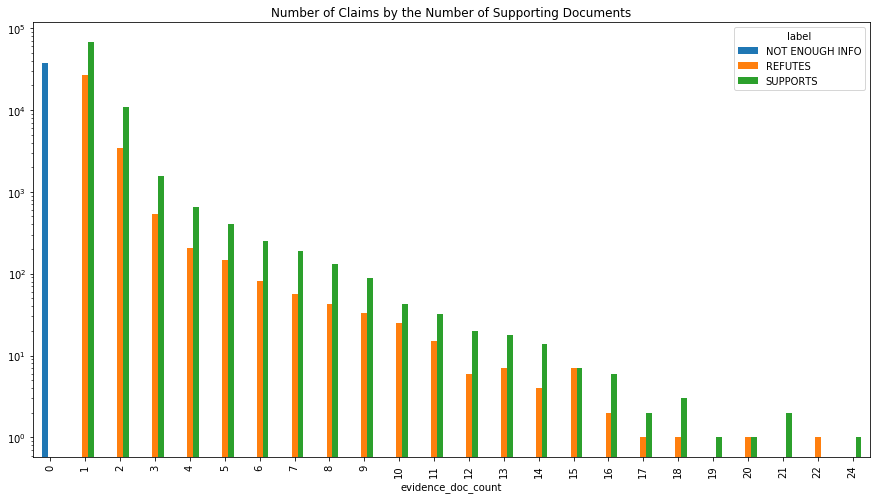

In [19]:
stat_df = lclaims_df.pivot_table(columns='label', index='evidence_doc_count',
                                 values='claim', aggfunc='count', fill_value=0)
stat_df.plot.bar(figsize=(15, 8), logy=True, title='Number of Claims by the Number of Supporting Documents')
plt.show()

### Most Popular Evidence

In [20]:
lclaims_df['evidence_set_str'] = lclaims_df.evidence_docs.astype(str)
mask = lclaims_df.label != 'NOT ENOUGH INFO'
evidence_stat = lclaims_df[mask].evidence_set_str.value_counts()
evidence_stat.index.name = 'evidence_set'
evidence_stat = evidence_stat.reset_index()
evidence_stat.head(20)

,evidence_set,evidence_set_str
0,{'Snoop_Dogg'},166
1,{'Wyatt_Earp'},151
2,{'United_Kingdom'},140
3,{'International_relations'},139
4,{'Marlon_Brando'},137
5,{'United_States'},132
6,{'Adele'},130
7,{'Abraham_Lincoln'},125
8,{'Miley_Cyrus'},120
9,{'Michael_Jackson'},119


In [21]:
evidence_stat = lclaims_df[mask].pivot_table(index=['evidence_set_str', 'evidence_doc_count'], 
                                             values='claim', aggfunc='count').reset_index()

### Claims with Multiple evidence

In [22]:
evidence_stat[evidence_stat.evidence_doc_count > 1].sort_values('claim', ascending=False).head(20)

,evidence_set_str,evidence_doc_count,claim
451,"{'A_Song_of_Ice_and_Fire', 'George_R._R._Martin'}",2,42
1473,"{'Audrey_Horne', 'Pilot_-LRB-Twin_Peaks-RRB-'}",2,32
5993,"{'Hot_-LRB-Mel_B_album-RRB-', 'Mel_B'}",2,26
14448,"{'Warm_Leatherette_-LRB-album-RRB-', 'Grace_Jones'}",2,26
5290,"{'Gift_of_the_Night_Fury', 'Jay_Baruchel'}",2,23
10830,"{'Richard_Nixon', 'Pat_Nixon'}",2,22
13560,"{'This_Sporting_Life', 'Lindsay_Anderson'}",2,20
6209,"{'In_&_Out_-LRB-film-RRB-', 'Joan_Cusack'}",2,20
5600,"{'Grégory_Levasseur', 'Furia_-LRB-film-RRB-'}",2,19
9015,"{'Mitt_Romney', 'Ann_Romney'}",2,19


In [23]:
evidence_stat[evidence_stat.evidence_doc_count > 3].sort_values('claim', ascending=False).head(20)

,evidence_set_str,evidence_doc_count,claim
5281,"{'Gift_of_the_Night_Fury', 'America_Ferrera', 'T._J._Miller', 'Craig_Ferguson', 'Jonah_Hill', 'G...",9,7
3636,"{'Days_of_Heaven', 'Richard_Gere', 'American_Gigolo', 'An_Officer_and_a_Gentleman'}",4,7
2031,"{'Birds_in_the_Trap_Sing_McKnight', 'Days_Before_Rodeo', 'Rodeo_-LRB-Travis_Scott_album-RRB-', '...",5,7
2674,"{'Castaway_-LRB-film-RRB-', 'Oliver_Reed', 'Gladiator_-LRB-2000_film-RRB-', 'The_Trap_-LRB-1966_...",4,5
9834,"{'Owen_Wilson', 'Gene_Hackman', 'The_Royal_Tenenbaums', 'Ben_Stiller', 'Bill_Murray', 'Danny_Glo...",7,5
8657,"{'Max_Minghella', 'Danny_Huston', 'Jeff_Bridges', 'How_to_Lose_Friends_&_Alienate_People_-LRB-fi...",5,5
5120,"{'Gendry', 'A_Game_of_Thrones', 'A_Storm_of_Swords', 'A_Clash_of_Kings', 'A_Feast_for_Crows'}",5,5
14628,"{'William_Hurt', 'The_Host_-LRB-2013_film-RRB-', 'Saoirse_Ronan', 'Jake_Abel', 'Diane_Kruger', '...",6,4
3663,"{'Dean_DeLeo', 'Stone_Temple_Pilots', 'Eric_Kretz', 'Scott_Weiland', 'Robert_DeLeo'}",5,4
4941,"{'Friends', 'The_Comeback_-LRB-TV_series-RRB-', 'Web_Therapy_-LRB-TV_series-RRB-', 'Lisa_Kudrow'}",4,4


In [24]:
lclaims_df[lclaims_df.evidence_doc_count > 10].head(20)

,claim,evidence,label,source,evidence_docs,evidence_doc_count,evidence_sentence_count,evidence_set_str
claim_id,,,,,,,,
877,Keith Urban is a singer.,"[[Break_on_Me, 1], [Keith_Urban_-LRB-1991_album-RRB-, 0], [Keith_Urban, 18], [Golden_Road_-LRB-a...",SUPPORTS,train,"{Fuse_-LRB-Keith_Urban_album-RRB-, But_for_the_Grace_of_God, Ripcord_-LRB-album-RRB-, The_Ranch_...",11,22,"{'Fuse_-LRB-Keith_Urban_album-RRB-', 'But_for_the_Grace_of_God', 'Ripcord_-LRB-album-RRB-', 'The..."
1885,Leonardo DiCaprio is an actor.,"[[Blood_Diamond, 0], [Leonardo_DiCaprio, 8], [Leonardo_DiCaprio, 1], [Inception, 1], [Shutter_Is...",SUPPORTS,train,"{Body_of_Lies_-LRB-film-RRB-, Romeo_+_Juliet, Blood_Diamond, The_Aviator_-LRB-2004_film-RRB-, Ap...",24,40,"{'Body_of_Lies_-LRB-film-RRB-', 'Romeo_+_Juliet', 'Blood_Diamond', 'The_Aviator_-LRB-2004_film-R..."
7253,Laurence Fishburne acted in a movie.,"[[Man_of_Steel_-LRB-film-RRB-, 4], [Othello_-LRB-1995_film-RRB-, 0], [Academy_Award_for_Best_Act...",SUPPORTS,train,"{The_Matrix_-LRB-franchise-RRB-, What's_Love_Got_to_Do_with_It_-LRB-film-RRB-, Othello_-LRB-1995...",11,27,"{'The_Matrix_-LRB-franchise-RRB-', ""What's_Love_Got_to_Do_with_It_-LRB-film-RRB-"", 'Othello_-LRB..."
7540,Scarlett Johansson is an actress.,"[[Lucy_-LRB-2014_film-RRB-, 0], [Scarlett_Johansson, 3], [Ghost_World_-LRB-film-RRB-, 0], [Manny...",SUPPORTS,train,"{Lucy_-LRB-2014_film-RRB-, North_-LRB-1994_film-RRB-, A_Love_Song_for_Bobby_Long, The_Prestige_-...",21,38,"{'Lucy_-LRB-2014_film-RRB-', 'North_-LRB-1994_film-RRB-', 'A_Love_Song_for_Bobby_Long', 'The_Pre..."
7541,Scarlett Johansson is an actress in films.,"[[Girl_with_a_Pearl_Earring_-LRB-film-RRB-, 16], [Lucy_-LRB-2014_film-RRB-, 0], [Ghost_World_-LR...",SUPPORTS,train,"{Marvel_Cinematic_Universe, Ghost_World_-LRB-film-RRB-, Lucy_-LRB-2014_film-RRB-, North_-LRB-199...",20,40,"{'Marvel_Cinematic_Universe', 'Ghost_World_-LRB-film-RRB-', 'Lucy_-LRB-2014_film-RRB-', 'North_-..."
7623,Slovakia is a warship.,"[[Slovakia, 4], [Democracy_Index, 0], [Slovakia, 19], [Social_security, 6], [Slovakia, 26], [Slo...",REFUTES,train,"{Velvet_Revolution, Official_language, Council_of_Europe, List_of_countries_by_real_GDP_growth_r...",16,39,"{'Velvet_Revolution', 'Official_language', 'Council_of_Europe', 'List_of_countries_by_real_GDP_g..."
7747,Julie Christie starred in a film.,"[[The_Go-Between_-LRB-1971_film-RRB-, 0], [Away_from_Her, 0], [Julie_Christie, 8], [Darling_-LRB...",SUPPORTS,train,"{Julie_Christie, Petulia, Fahrenheit_451_-LRB-film-RRB-, McCabe_&_Mrs._Miller, The_Go-Between_-L...",13,17,"{'Julie_Christie', 'Petulia', 'Fahrenheit_451_-LRB-film-RRB-', 'McCabe_&_Mrs._Miller', 'The_Go-B..."
7886,George W. Bush was a president.,"[[George_W._Bush, 10], [George_W._Bush, 28], [Barbara_Bush, 1], [George_W._Bush, 5], [United_Sta...",SUPPORTS,train,"{Prescott_Bush, Bush_tax_cuts, Public_image_of_George_W._Bush, United_States_presidential_electi...",14,30,"{'Prescott_Bush', 'Bush_tax_cuts', 'Public_image_of_George_W._Bush', 'United_States_presidential..."
8089,Gennady Golovkin boxes.,"[[Gennady_Golovkin, 5], [Interim_championship, 0], [Milton_Núñez_-LRB-boxer-RRB-, 1], [Gennady...",SUPPORTS,train,"{Boxing_styles_and_technique, International_Boxing_Organization, Knockout, Milton_Núñez_-LRB-b...",16,28,"{'Boxing_styles_and_technique', 'International_Boxing_Organization', 'Knockout', 'Milton_Núñez..."


In [25]:
lclaims_df.to_json('data/l_claims.json')

# Explore claims

In [26]:
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

## Read Claims list

In [27]:
claims_df = pd.read_csv('data/claims.csv', index_col='claim_id')

## Calculate features

In [28]:
%%time
records = []
for claim_id, claim in claims_df.claim.items():
    doc = nlp(claim)
    if (claim_id % 1000 == 0):
        print(claim_id)
    
    record = dict(
        claim_id = claim_id,
        named_entities = [{'entity': span.text, 'label': span.label_, 'root': span.root.text} for span in doc.ents],
        noun_chunks = [{'noun_phrase': span.text, 'root': span.root.text} for span in doc.noun_chunks]
    )
    records.append(record)
    #print()

2000
3000
4000
5000
7000
8000
9000
12000
14000
15000
16000
17000
18000
21000
22000
23000
24000
27000
28000
29000
30000
32000
33000
34000
35000
36000
37000
39000
42000
43000
44000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
57000
58000
60000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
73000
74000
76000
77000
79000
80000
81000
82000
84000
85000
86000
87000
88000
90000
91000
92000
93000
94000
95000
97000
101000
102000
105000
107000
108000
109000
110000
112000
113000
114000
115000
116000
117000
118000
119000
120000
122000
123000
126000
128000
129000
132000
133000
134000
135000
136000
137000
139000
140000
141000
143000
144000
146000
147000
148000
150000
151000
152000
154000
156000
157000
160000
161000
162000
163000
164000
165000
166000
167000
168000
169000
170000
171000
173000
174000
175000
176000
177000
178000
179000
180000
181000
183000
184000
187000
188000
190000
191000
194000
195000
197000
198000
200000
201000
202000
203000
205000
206000
207000
208000
209

In [29]:
claims_features_df = pd.DataFrame.from_records(records, index='claim_id')
claims_features_df.rename(columns={'noun_chunks': 'noun_phrases'}, inplace=True)

In [30]:
claims_features_df['entity_count'] = claims_features_df.named_entities.apply(len)
claims_features_df['entity_types'] = claims_features_df.named_entities.apply(lambda x: {item['label'] for item in x})
claims_features_df['entity_types_count'] = claims_features_df.entity_types.apply(len)

In [31]:
claims_features_df['np_count'] = claims_features_df.noun_phrases.apply(len)
claims_features_df['np_phrase'] = claims_features_df.noun_phrases.apply(lambda x: {item['noun_phrase'] for item in x})
claims_features_df['np_roots'] = claims_features_df.noun_phrases.apply(lambda x: {item['root'] for item in x})

## Export claims with features

In [32]:
claims_df = claims_df.join(claims_features_df)

In [33]:
claims_df.head(5)

,claim,source,named_entities,noun_phrases,entity_count,entity_types,entity_types_count,np_count,np_phrase,np_roots
claim_id,,,,,,,,,,
3,Chris Hemsworth appeared in A Perfect Getaway.,train,"[{'entity': 'Chris Hemsworth', 'label': 'PERSON', 'root': 'Hemsworth'}, {'entity': 'A Perfect Ge...","[{'noun_phrase': 'Chris Hemsworth', 'root': 'Hemsworth'}, {'noun_phrase': 'A Perfect Getaway', '...",2,"{WORK_OF_ART, PERSON}",2,2,"{Chris Hemsworth, A Perfect Getaway}","{Getaway, Hemsworth}"
4,Chris Hemsworth disappeared in A Perfect Getaway.,train,"[{'entity': 'Chris Hemsworth', 'label': 'PERSON', 'root': 'Hemsworth'}, {'entity': 'A Perfect Ge...","[{'noun_phrase': 'Chris Hemsworth', 'root': 'Hemsworth'}, {'noun_phrase': 'A Perfect Getaway', '...",2,"{WORK_OF_ART, PERSON}",2,2,"{Chris Hemsworth, A Perfect Getaway}","{Getaway, Hemsworth}"
6,Firefox is an application.,test,"[{'entity': 'Firefox', 'label': 'ORG', 'root': 'Firefox'}]","[{'noun_phrase': 'Firefox', 'root': 'Firefox'}, {'noun_phrase': 'an application', 'root': 'appli...",1,{ORG},1,2,"{Firefox, an application}","{Firefox, application}"
7,Roald Dahl is a writer.,train,"[{'entity': 'Roald Dahl', 'label': 'PERSON', 'root': 'Dahl'}]","[{'noun_phrase': 'Roald Dahl', 'root': 'Dahl'}, {'noun_phrase': 'a writer', 'root': 'writer'}]",1,{PERSON},1,2,"{a writer, Roald Dahl}","{Dahl, writer}"
8,Roald Dahl is a governor.,train,"[{'entity': 'Roald Dahl', 'label': 'PERSON', 'root': 'Dahl'}]","[{'noun_phrase': 'Roald Dahl', 'root': 'Dahl'}, {'noun_phrase': 'a governor', 'root': 'governor'}]",1,{PERSON},1,2,"{a governor, Roald Dahl}","{Dahl, governor}"


In [34]:
claims_df.to_json('data/claims_lm.json')

## Top entity types

In [35]:
claims_features_df['entity_types_str'] = claims_features_df.entity_types.astype(str)
claims_features_df.reset_index(inplace=True)
#claims_data_df['entity_types_count'] = claims_data_df.entity_types.apply(len)

In [36]:
claims_features_df

,claim_id,named_entities,noun_phrases,entity_count,entity_types,entity_types_count,np_count,np_phrase,np_roots,entity_types_str
0,3,"[{'entity': 'Chris Hemsworth', 'label': 'PERSON', 'root': 'Hemsworth'}, {'entity': 'A Perfect Ge...","[{'noun_phrase': 'Chris Hemsworth', 'root': 'Hemsworth'}, {'noun_phrase': 'A Perfect Getaway', '...",2,"{WORK_OF_ART, PERSON}",2,2,"{Chris Hemsworth, A Perfect Getaway}","{Getaway, Hemsworth}","{'WORK_OF_ART', 'PERSON'}"
1,4,"[{'entity': 'Chris Hemsworth', 'label': 'PERSON', 'root': 'Hemsworth'}, {'entity': 'A Perfect Ge...","[{'noun_phrase': 'Chris Hemsworth', 'root': 'Hemsworth'}, {'noun_phrase': 'A Perfect Getaway', '...",2,"{WORK_OF_ART, PERSON}",2,2,"{Chris Hemsworth, A Perfect Getaway}","{Getaway, Hemsworth}","{'WORK_OF_ART', 'PERSON'}"
2,6,"[{'entity': 'Firefox', 'label': 'ORG', 'root': 'Firefox'}]","[{'noun_phrase': 'Firefox', 'root': 'Firefox'}, {'noun_phrase': 'an application', 'root': 'appli...",1,{ORG},1,2,"{Firefox, an application}","{Firefox, application}",{'ORG'}
3,7,"[{'entity': 'Roald Dahl', 'label': 'PERSON', 'root': 'Dahl'}]","[{'noun_phrase': 'Roald Dahl', 'root': 'Dahl'}, {'noun_phrase': 'a writer', 'root': 'writer'}]",1,{PERSON},1,2,"{a writer, Roald Dahl}","{Dahl, writer}",{'PERSON'}
4,8,"[{'entity': 'Roald Dahl', 'label': 'PERSON', 'root': 'Dahl'}]","[{'noun_phrase': 'Roald Dahl', 'root': 'Dahl'}, {'noun_phrase': 'a governor', 'root': 'governor'}]",1,{PERSON},1,2,"{a governor, Roald Dahl}","{Dahl, governor}",{'PERSON'}
5,9,"[{'entity': 'Ireland', 'label': 'GPE', 'root': 'Ireland'}]","[{'noun_phrase': 'Ireland', 'root': 'Ireland'}, {'noun_phrase': 'relatively low-lying mountains'...",1,{GPE},1,2,"{Ireland, relatively low-lying mountains}","{Ireland, mountains}",{'GPE'}
6,10,"[{'entity': 'Ireland', 'label': 'GPE', 'root': 'Ireland'}]","[{'noun_phrase': 'Ireland', 'root': 'Ireland'}, {'noun_phrase': 'relatively low-lying mountains'...",1,{GPE},1,2,"{Ireland, relatively low-lying mountains}","{Ireland, mountains}",{'GPE'}
7,11,"[{'entity': 'Carlos Santana', 'label': 'PERSON', 'root': 'Santana'}, {'entity': 'Santana', 'labe...","[{'noun_phrase': 'Carlos Santana', 'root': 'Santana'}, {'noun_phrase': 'Santana', 'root': 'Santa...",3,"{PERSON, DATE}",2,2,"{Carlos Santana, Santana}",{Santana},"{'PERSON', 'DATE'}"
8,12,"[{'entity': 'Carlos Santana', 'label': 'PERSON', 'root': 'Santana'}, {'entity': 'Santana', 'labe...","[{'noun_phrase': 'Carlos Santana', 'root': 'Santana'}, {'noun_phrase': 'Santana', 'root': 'Santa...",3,"{PERSON, DATE}",2,2,"{Carlos Santana, Santana}",{Santana},"{'PERSON', 'DATE'}"
9,13,"[{'entity': 'David Thewis', 'label': 'PERSON', 'root': 'Thewis'}]","[{'noun_phrase': 'David Thewis', 'root': 'Thewis'}, {'noun_phrase': 'many notable performances',...",1,{PERSON},1,2,"{David Thewis, many notable performances}","{Thewis, performances}",{'PERSON'}


In [37]:
df = claims_features_df.pivot_table(index=['entity_types_count', 'entity_types_str'], 
                           aggfunc='count', values='claim_id').reset_index()
df.rename(columns={'claim_id': 'claims_count'}, inplace=True)
df.sort_values(['entity_types_count', 'claims_count'], ascending=[True, False]).reset_index(drop=True)

,entity_types_count,entity_types_str,claims_count
0,0,set(),11646
1,1,{'PERSON'},44981
2,1,{'ORG'},13589
3,1,{'GPE'},8146
4,1,{'DATE'},3021
5,1,{'NORP'},2071
6,1,{'CARDINAL'},1409
7,1,{'WORK_OF_ART'},1069
8,1,{'LOC'},937
9,1,{'PRODUCT'},439


In [38]:
df = claims_features_df.pivot_table(index=['np_count'], 
                           aggfunc='count', values='claim_id').reset_index()
df.rename(columns={'claim_id': 'claims_count'}, inplace=True)
df.sort_values(['np_count'], ascending=[True]).reset_index(drop=True)

,np_count,claims_count
0,0,145
1,1,13291
2,2,86872
3,3,45613
4,4,14030
5,5,3735
6,6,1012
7,7,290
8,8,122
9,9,86


In [39]:
claims_df[claims_df.np_count == 0]

,claim,source,named_entities,noun_phrases,entity_count,entity_types,entity_types_count,np_count,np_phrase,np_roots
claim_id,,,,,,,,,,
1443,Michael J. Fox semi-retired from acting in 2000.,train,"[{'entity': 'Michael J. Fox', 'label': 'PERSON', 'root': 'Fox'}, {'entity': '2000', 'label': 'DA...",[],2,"{PERSON, DATE}",2,0,{},{}
6344,There are at least 10 James Bond shows.,train,"[{'entity': 'at least 10', 'label': 'CARDINAL', 'root': '10'}, {'entity': 'James Bond', 'label':...",[],2,"{PERSON, CARDINAL}",2,0,{},{}
8692,The Conjuring 2 was released in 2016.,train,"[{'entity': 'The Conjuring 2', 'label': 'ORG', 'root': '2'}, {'entity': '2016', 'label': 'DATE',...",[],2,"{DATE, ORG}",2,0,{},{}
9532,Younger premiered in 2015.,test,"[{'entity': '2015', 'label': 'DATE', 'root': '2015'}]",[],1,{DATE},1,0,{},{}
10670,Flaked was cancelled in 2016.,test,"[{'entity': '2016', 'label': 'DATE', 'root': '2016'}]",[],1,{DATE},1,0,{},{}
11486,Furious 7 is American.,train,"[{'entity': 'American', 'label': 'NORP', 'root': 'American'}]",[],1,{NORP},1,0,{},{}
12059,MS-13 is kind.,test,[],[],0,{},0,0,{},{}
13095,Furious 7 began filming in 2013.,train,"[{'entity': '2013', 'label': 'DATE', 'root': '2013'}]",[],1,{DATE},1,0,{},{}
13096,Furious 7 began showing in 2013.,train,"[{'entity': '2013', 'label': 'DATE', 'root': '2013'}]",[],1,{DATE},1,0,{},{}
